In [85]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import grid_search_params as gsp
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_missing_value, plot_actual_vs_prediction, plot_residual

### Import Dataset

In [72]:
data = pd.read_csv('E:\Data Science\Python\machine learning exercises\dataset\\taxi_fare.csv', parse_dates=['pickup_datetime'])
data

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0
...,...,...,...,...,...,...,...
18914,22.5,2013-06-02 01:13:00,-73.997090,40.720635,-73.971983,40.794597,2.0
18915,5.5,2014-10-15 14:47:00,-73.979980,40.751825,-73.973952,40.759965,1.0
18916,6.5,2015-06-28 13:00:47,-73.982315,40.762691,-73.993202,40.767578,1.0
18917,5.3,2011-10-28 17:48:45,-74.001457,40.739338,-73.993607,40.751885,1.0


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18919 entries, 0 to 18918
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        18919 non-null  float64       
 1   pickup_datetime    18919 non-null  datetime64[ns]
 2   pickup_longitude   18919 non-null  float64       
 3   pickup_latitude    18919 non-null  float64       
 4   dropoff_longitude  18919 non-null  float64       
 5   dropoff_latitude   18919 non-null  float64       
 6   passenger_count    18918 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 MB


,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


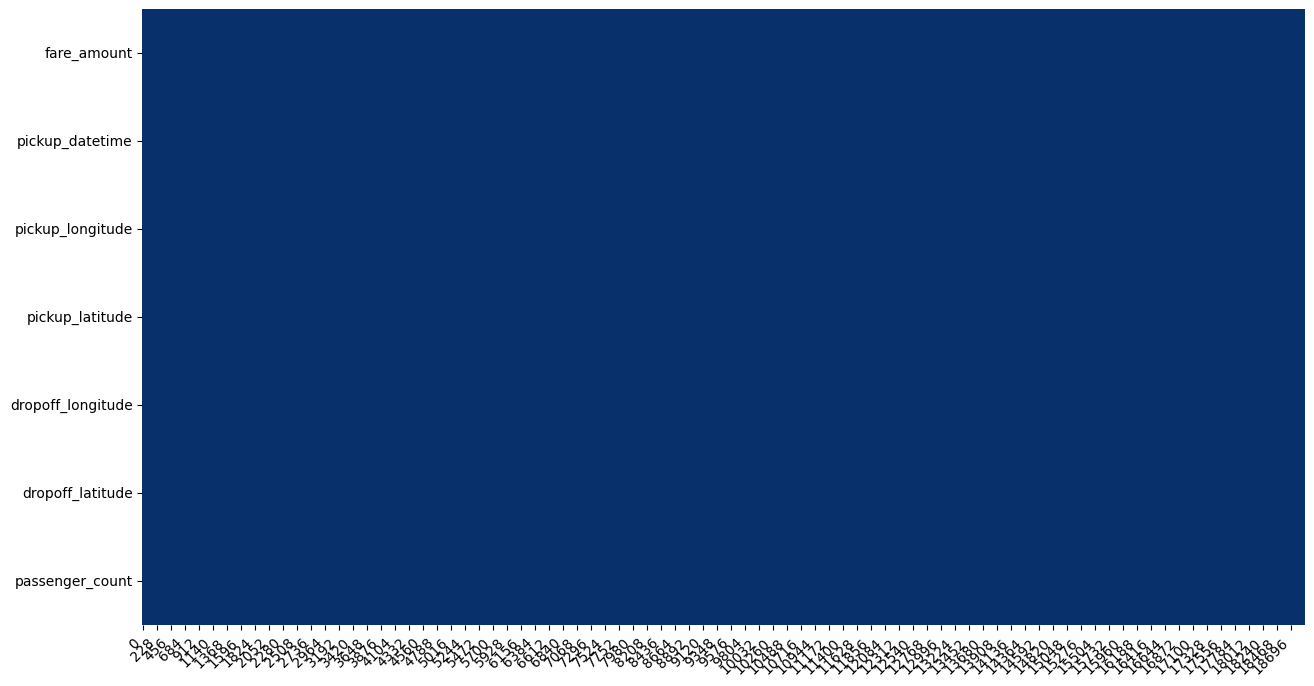

In [74]:
plot_missing_value(data, return_df=True)

In [75]:
data.dropna(inplace=True)

### Extract Time

In [76]:
pickup_dt = data.pickup_datetime.dt

In [77]:
data['year'] = pickup_dt.year
data['month'] = pickup_dt.month
data['day'] = pickup_dt.day_of_week
data['hour'] = pickup_dt.hour
data.drop(labels=['pickup_datetime'], axis=1, inplace=True)

In [78]:
data

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7
...,...,...,...,...,...,...,...,...,...,...
18913,9.5,-73.990838,40.744963,-73.973974,40.760330,1.0,2013,3,1,7
18914,22.5,-73.997090,40.720635,-73.971983,40.794597,2.0,2013,6,6,1
18915,5.5,-73.979980,40.751825,-73.973952,40.759965,1.0,2014,10,2,14
18916,6.5,-73.982315,40.762691,-73.993202,40.767578,1.0,2015,6,6,13


### Extract Distance

In [79]:
# menggunakan manhatance distance
# fromula |P1 - P2| -> |x1-x2| + |y1-y2|
data['distance'] =  np.abs(data.pickup_latitude - data.dropoff_latitude) + np.abs(data.pickup_longitude - data.dropoff_longitude)
data.drop(labels=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
data

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194
...,...,...,...,...,...,...,...
18913,9.5,1.0,2013,3,1,7,0.032231
18914,22.5,2.0,2013,6,6,1,0.099069
18915,5.5,1.0,2014,10,2,14,0.014168
18916,6.5,1.0,2015,6,6,13,0.015774


### Dataset Splitting

In [80]:
X = data.drop('fare_amount', axis=1)
y = data.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [81]:
gsp.linreg_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False]}

In [82]:
data.columns

Index(['fare_amount', 'passenger_count', 'year', 'month', 'day', 'hour',
       'distance'],
      dtype='object')

In [83]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['passenger_count', 'distance', 'year']),
    ('categoric', cat_pipe(encoder='onehot'), ['day', 'month', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(estimator=pipeline, cv=3, n_jobs=-1, verbose=1, param_grid=gsp.linreg_poly_params)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.best_score_, model.score(X_train,  y_train), model.score(X_test, y_test))


Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.0156178975175425 0.023086762040744446 0.019173502818968458


### Hasil Model Jelek. Lanjut Improve

# Evaluasi Model

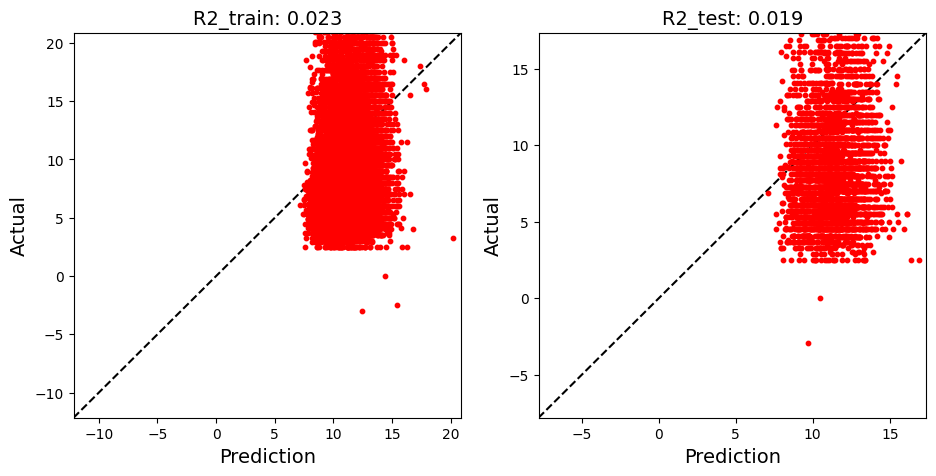

In [84]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

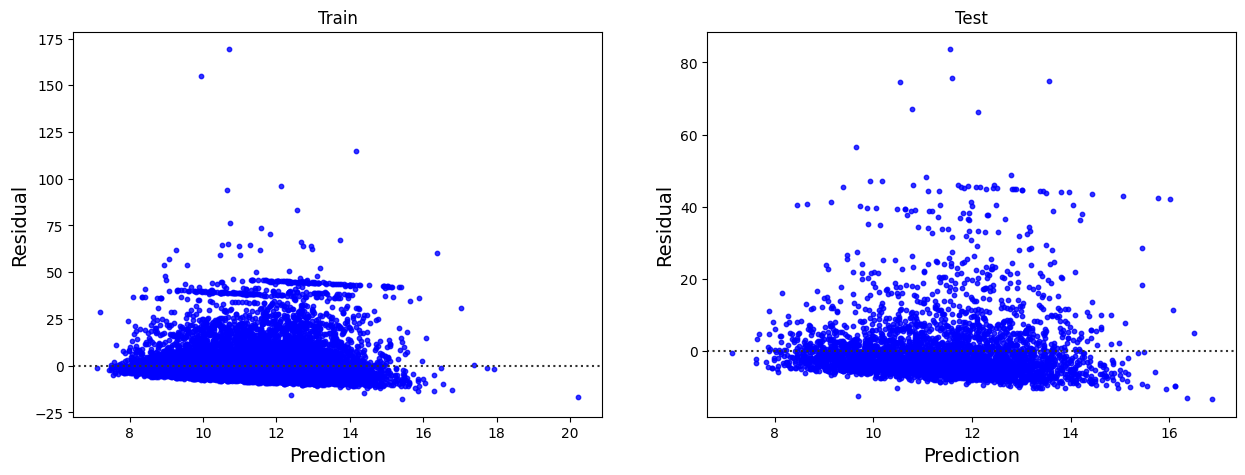

In [86]:
plot_residual(X_train, y_train, X_test, y_test, model) # Hasil, fitur pada dataset masih unbalance 

In [88]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'distance', 'year']),
    ('categoric', cat_pipe(encoder='onehot'), ['day', 'month', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(estimator=pipeline, cv=3, n_jobs=-1, verbose=1, param_grid=gsp.linreg_poly_params)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.best_score_, model.score(X_train,  y_train), model.score(X_test, y_test))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7157898850270392 0.7195507788386306 0.7465877327920035


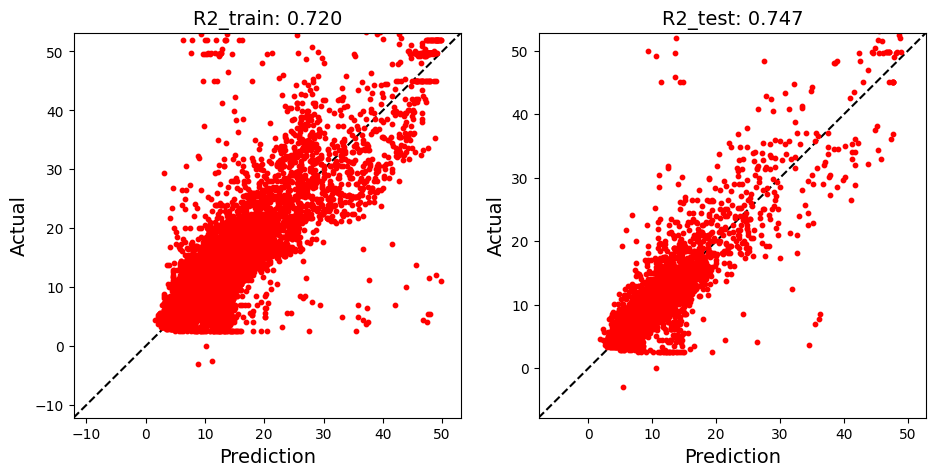

In [89]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

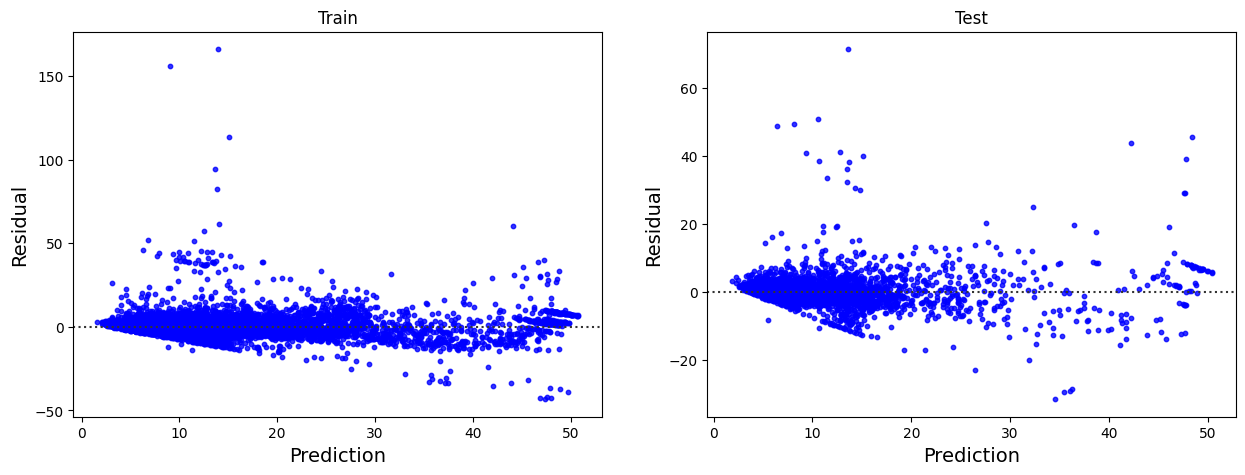

In [90]:
plot_residual(X_train, y_train, X_test, y_test, model) # Hasil, masih ada sedikit problem, kali ini menyangkut heterocedasity